In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("./alldata.xlsx")
df

,Date,Price,Open,High,Low,Vol.,Change %,FEDFUNDS,Gold
0,2010-07-18,0.1,0.0,0.1,0.1,0.08,0.00,0.18,1204.7500
1,2010-07-19,0.1,0.1,0.1,0.1,0.57,0.00,0.18,1190.2500
2,2010-07-20,0.1,0.1,0.1,0.1,0.26,0.00,0.18,1181.5000
3,2010-07-21,0.1,0.1,0.1,0.1,0.58,0.00,0.18,1191.2500
4,2010-07-22,0.1,0.1,0.1,0.1,2.16,0.00,0.18,1187.0000
...,...,...,...,...,...,...,...,...,...
4932,2024-01-18,41292.7,42763.5,42908.0,40682.6,70.35,-3.45,5.33,2023.1038
4933,2024-01-19,41648.0,41293.8,42164.6,40305.4,72.64,0.86,5.33,2029.6244
4934,2024-01-20,41695.4,41647.6,41858.0,41449.5,22.27,0.11,5.33,2029.6244
4935,2024-01-21,41583.2,41695.4,41878.0,41504.5,16.11,-0.27,5.33,2029.6244


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937 entries, 0 to 4936
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4937 non-null   datetime64[ns]
 1   Price     4937 non-null   float64       
 2   Open      4937 non-null   float64       
 3   High      4937 non-null   float64       
 4   Low       4937 non-null   float64       
 5   Vol.      4937 non-null   float64       
 6   Change %  4937 non-null   float64       
 7   FEDFUNDS  4937 non-null   float64       
 8   Gold      4937 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 347.3 KB


In [4]:
null_rows = df[df.isnull().any(axis=1)]

# Hiển thị kết quả
print("Các hàng có giá trị null:")
print(null_rows)

Các hàng có giá trị null:
Empty DataFrame
Columns: [Date, Price, Open, High, Low, Vol., Change %, FEDFUNDS, Gold]
Index: []


<Axes: >

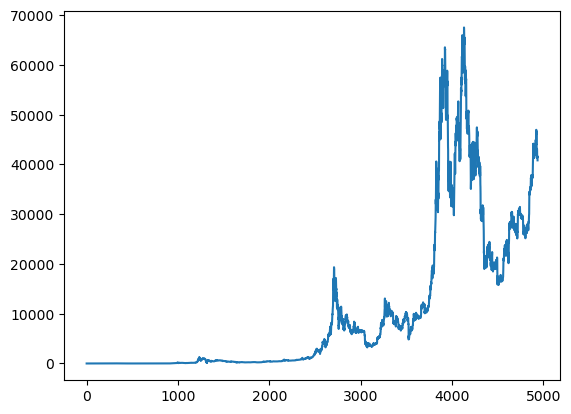

In [5]:
df['Price'].plot()

In [7]:
matrix = df.iloc[:, 1:].to_numpy()
matrix

array([[ 1.0000000e-01,  0.0000000e+00,  1.0000000e-01, ...,
         0.0000000e+00,  1.8000000e-01,  1.2047500e+03],
       [ 1.0000000e-01,  1.0000000e-01,  1.0000000e-01, ...,
         0.0000000e+00,  1.8000000e-01,  1.1902500e+03],
       [ 1.0000000e-01,  1.0000000e-01,  1.0000000e-01, ...,
         0.0000000e+00,  1.8000000e-01,  1.1815000e+03],
       ...,
       [ 4.1695400e+04,  4.1647600e+04,  4.1858000e+04, ...,
         1.1000000e-01,  5.3300000e+00,  2.0296244e+03],
       [ 4.1583200e+04,  4.1695400e+04,  4.1878000e+04, ...,
        -2.7000000e-01,  5.3300000e+00,  2.0296244e+03],
       [ 4.0825800e+04,  4.1581700e+04,  4.1684900e+04, ...,
        -1.8200000e+00,  5.3300000e+00,  2.0267500e+03]])

In [8]:
# Kích thước của sliding window
window_size = (10, 8)

# List để lưu trữ các window
data_list = []

# Duyệt qua từng hàng để tạo sliding window
for i in range(len(matrix) - window_size[0] + 1):
    window = matrix[i:i+window_size[0], :]
    data_list.append(window)

# Chuyển danh sách thành mảng numpy nếu cần
data_list = np.array(data_list)

# In thông tin về mảng windows_array
print(data_list.shape)


(4928, 10, 8)


In [12]:
train = data_list[:4550]
other = data_list[4550:]

print(train.shape)
print(other.shape)

(4550, 10, 8)
(378, 10, 8)


In [13]:
val = other[:365]
test = other[365:]

print(val.shape)
print(test.shape)

(365, 10, 8)
(13, 10, 8)


In [25]:
X_train = train[:, :9, :]
y_train = train[:, 9:, :]

print(X_train.shape)
print(y_train.shape)

(4550, 9, 8)
(4550, 1, 8)


In [31]:
X_val = val[:, :9, :]
y_val = val[:, 9:, :]

print(X_val.shape)
print(y_val.shape)

(365, 9, 8)
(365, 1, 8)


In [32]:
X_test = test[:, :9, :]
y_test = test[:, 9:, :]

print(X_test.shape)
print(y_test.shape)

(13, 9, 8)
(13, 1, 8)


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Tạo mô hình
model = Sequential()
model.add(Conv1D(20, kernel_size=3, activation='relu', input_shape=(9, 8)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='linear'))

# Biên soạn mô hình với hàm mất mát mean_absolute_percentage_error và trình tối ưu Adam
model.compile(loss='mean_absolute_percentage_error', optimizer=Adam())

# Hiển thị cấu trúc của mô hình
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 7, 20)             500       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 3, 20)             0         
 g1D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 60)                0         
                                                                 
 dense_20 (Dense)            (None, 16)                976       
                                                                 
 dense_21 (Dense)            (None, 8)                 136       
                                                                 
Total params: 1612 (6.30 KB)
Trainable params: 1612 (6.30 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [44]:
# Huấn luyện mô hình với dữ liệu X_train và y_train, sử dụng dữ liệu validation X_val và y_val
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/100
285/285 [==============================] - 1s 2ms/step - loss: 2531791360.0000 - val_loss: 483141888.0000
Epoch 2/100
285/285 [==============================] - 1s 2ms/step - loss: 2013419648.0000 - val_loss: 73349016.0000
Epoch 3/100
285/285 [==============================] - 1s 2ms/step - loss: 1406487424.0000 - val_loss: 236246672.0000
Epoch 4/100
285/285 [==============================] - 1s 2ms/step - loss: 973731200.0000 - val_loss: 195385600.0000
Epoch 5/100
285/285 [==============================] - 1s 2ms/step - loss: 1267922304.0000 - val_loss: 27651384.0000
Epoch 6/100
285/285 [==============================] - 1s 2ms/step - loss: 765730304.0000 - val_loss: 176758496.0000
Epoch 7/100
285/285 [==============================] - 1s 2ms/step - loss: 815782400.0000 - val_loss: 18001358.0000
Epoch 8/100
285/285 [==============================] - 1s 2ms/step - loss: 700381184.0000 - val_loss: 163145872.0000
Epoch 9/100
285/285 [==============================] - 1s 2ms/s

1/1 [==============================] - 0s 20ms/step - loss: 99.6033
Validation Loss: 99.60331726074219


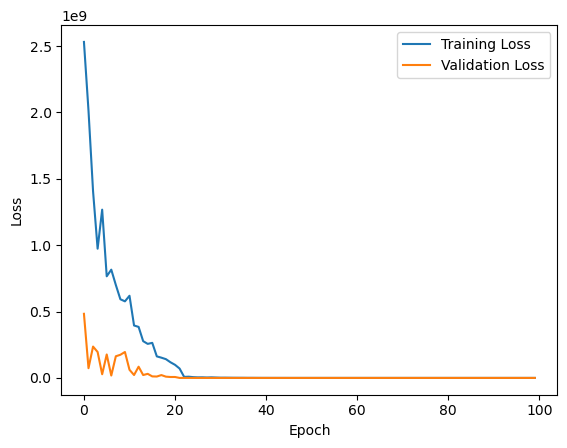

In [45]:
# Đánh giá mô hình trên tập validation
test_loss = model.evaluate(X_test, y_test)
print(f'Validation Loss: {test_loss}')

# In biểu đồ sự tiến triển của mô hình
import matplotlib.pyplot as plt
    
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
y_pred = model.predict(X_test)

# Chuyển đổi dữ liệu về dạng 1D để sử dụng hàm mean_absolute_error
y_test_flat = np.reshape(y_test, (-1,))
y_pred_flat = np.reshape(y_pred, (-1,))

# Tính mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_flat, y_pred_flat) * 100

print(f'Mean Absolute Percentage Error on Test Set: {mape:.2f}%')

1/1 [==============================] - 0s 52ms/step
Mean Absolute Percentage Error on Test Set: 99.60%
